# Overview
The following are some steps that need to be considered to develop a predictive model:
- **Data Preprocessing**
    - Data Cleaning - perform a univariate analysis and remove outlier/illegitmate data
    - Data Preparation
      - Spatial clustering and time binning
      - Smoothing
      - Time Series and Fourirer Transforms
- **Baseline Modeling**
    - Simple Moving Averages - uses previous n values to predict next value
    - Weight Moving Averages - assigns higher weights to more recent data, decreasing for older
- **Regression Modeling**
    - Linear Regression
    - Random Forest Regressor
    - XGBoost Regressor
- **Model Evaluation**
    - Creating and comparison of error metrics

# Data Preprocessing
## Data Fields

For our temporal-spatial analysis, the main fields we will need are time and space-related fields. Of the fields provided to us in the Levrum data, the following fit the criteria:
- Time
    - |Dispatched|
        - Call time
        - Format: MM/DD/YY HH:MM:SS AM/PM
- Space
    - |Latitude|
    - |Longitude|

Additional fields of interest are:
- |CauseCategory|
    - Category of call, interested in only looking at *EMS* for now

## Time Series Modeling
Before introducing new variables, we will first take a look at a simple time series model. 

### Preprocessing
In this step, we will be importing the data and preprocessing the data.

In [29]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

import h3
import folium
import branca.colormap as cm

In [30]:
# Read CSV
df = pd.read_csv('CLT_Data.csv')

# Filter to EMS data
ems_df = df[df['CauseCategory'] == 'EMS'].reset_index()

# Convert 'Dispatched' column to datetime format
ems_df['Dispatched'] = pd.to_datetime(ems_df['Dispatched'])

# Get Date from 'Dispatched'
ems_df['Date'] = ems_df['Dispatched'].dt.date

# Breakout dates and time from 'Dispatched'
ems_df['Date'] = ems_df['Dispatched'].dt.date
ems_df['Year'] = ems_df['Dispatched'].dt.year
ems_df['Month'] = ems_df['Dispatched'].dt.month
ems_df['Day'] = ems_df['Dispatched'].dt.day
ems_df['Time'] = ems_df['Dispatched'].dt.time

# Call frequency by date
freq_count = ems_df.groupby('Date').size().reset_index(name='Count')

freq_count

,Date,Count
0,2018-07-01,287
1,2018-07-02,285
2,2018-07-03,279
3,2018-07-04,225
4,2018-07-05,267
...,...,...
2187,2024-06-26,220
2188,2024-06-27,240
2189,2024-06-28,218
2190,2024-06-29,207


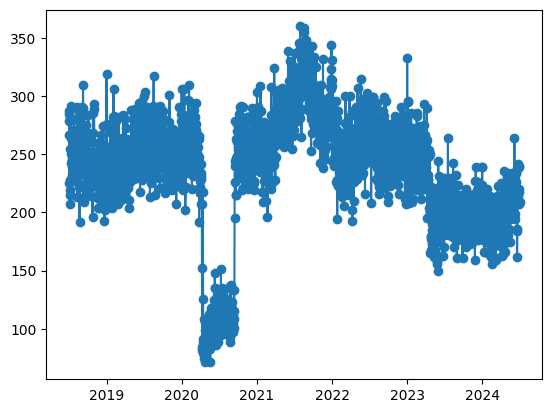

In [31]:
# Plot data
plt.plot(freq_count['Date'], freq_count['Count'], marker='o', linestyle='-')
plt.show()

### Review YoY

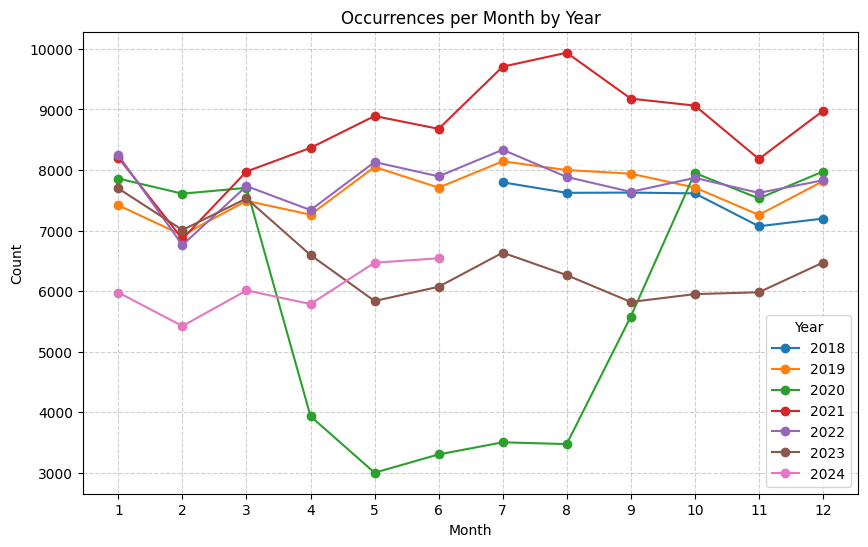

In [32]:
# Aggregate data by Year and Month
yoy_df = ems_df.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Create plot
plt.figure(figsize=(10, 6))

# Plot each year's data separately
for year in yoy_df['Year'].unique():
    subset = yoy_df[yoy_df['Year'] == year]
    plt.plot(subset['Month'], subset['Count'], marker='o', label=f"{year}")

# Labels and Title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Occurrences per Month by Year')
plt.xticks(range(1, 13))  # Ensure all 12 months appear on the x-axis
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

### 2019 Review
Data begins in 2018, but only have half a year's worth of data.

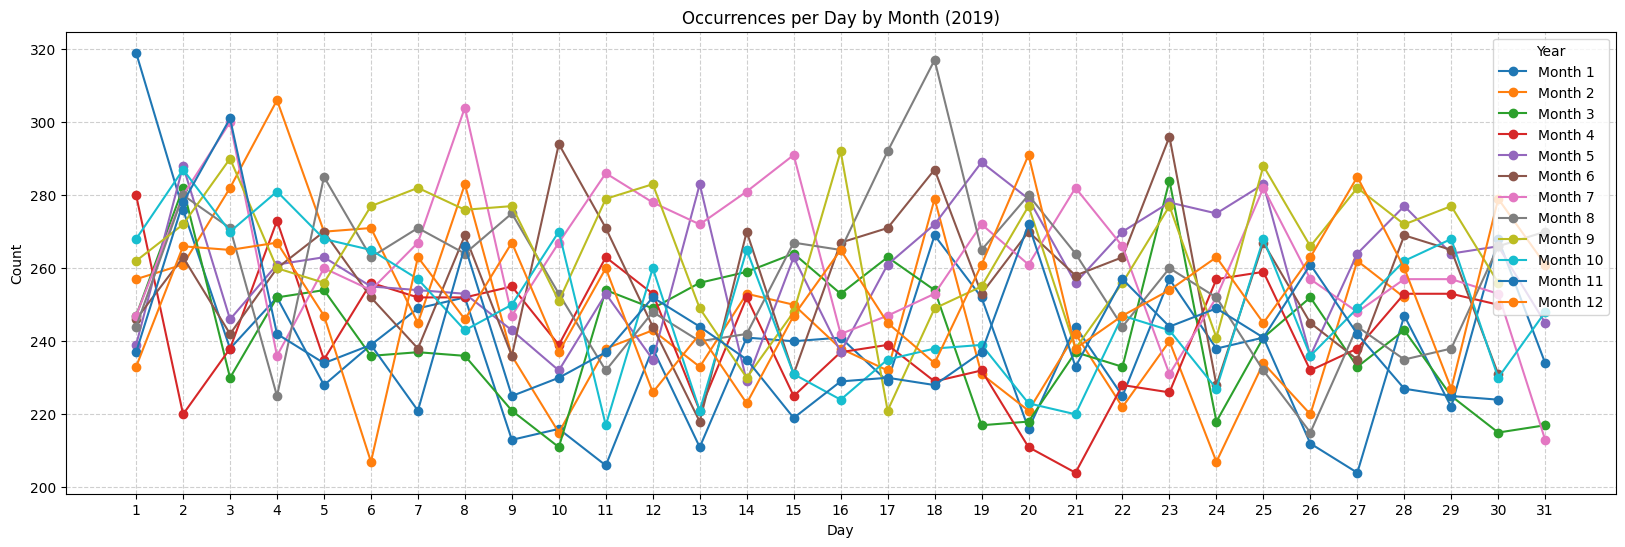

In [33]:
# 2019 data aggregated by Month and Day
df19 = ems_df[ems_df['Year'] == 2019].groupby(['Month', 'Day']).size().reset_index(name='Count')

# Create plot
plt.figure(figsize=(20, 6))

# Plot each month's data separately
for month in df19['Month'].unique():
    subset = df19[df19['Month'] == month]
    plt.plot(subset['Day'], subset['Count'], marker='o', label=f"Month {month}")

# Labels and Title
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Occurrences per Day by Month (2019)')
plt.xticks(range(1, 32))  # Ensure all 31 days appear on the x-axis
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

### 2021 Review
Skipping 2020 due to low call volume - possibly due to COVID

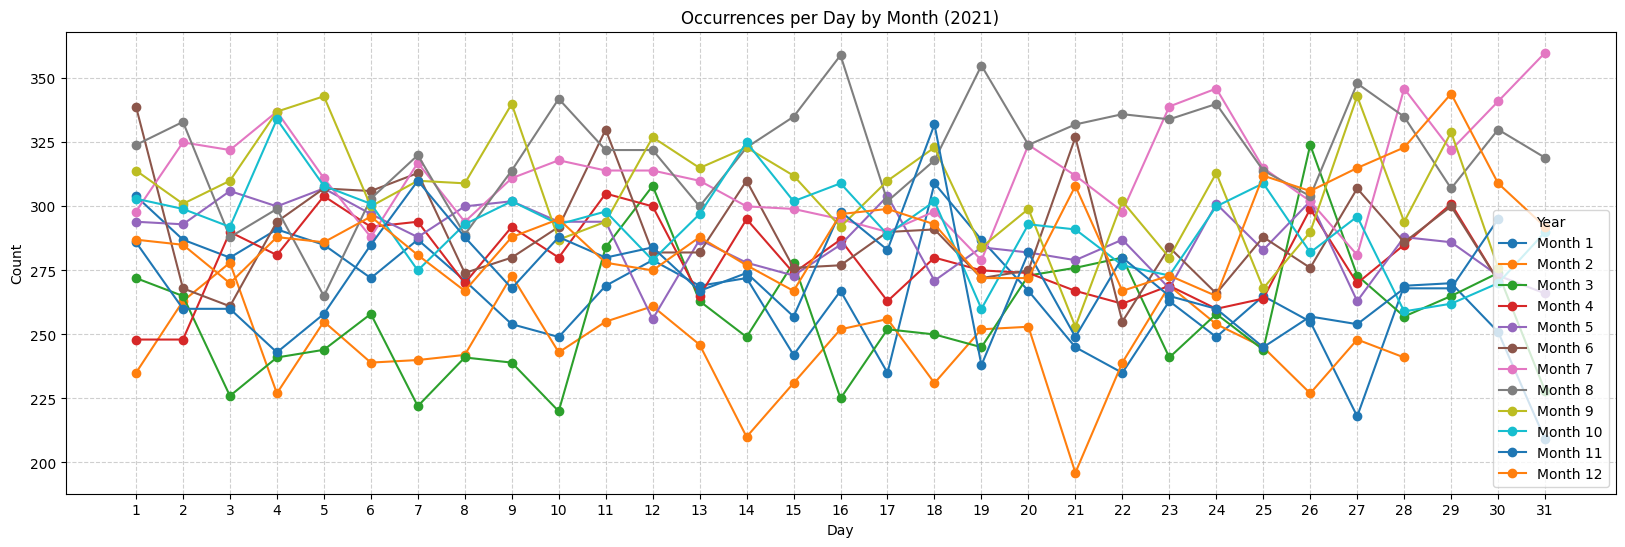

In [34]:
# 2021 data aggregated by Month and Day
df21 = ems_df[ems_df['Year'] == 2021].groupby(['Month', 'Day']).size().reset_index(name='Count')

# Create plot
plt.figure(figsize=(20, 6))

# Plot each month's data separately
for month in df21['Month'].unique():
    subset = df21[df21['Month'] == month]
    plt.plot(subset['Day'], subset['Count'], marker='o', label=f"Month {month}")

# Labels and Title
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Occurrences per Day by Month (2021)')
plt.xticks(range(1, 32))  # Ensure all 31 days appear on the x-axis
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

### Building the Model - Random Tree Regression

#### Import Libraries

In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

#### Preprocess Data Formats to Work with Scikit
Categorical Features: Text-based variable (e.g. Dates) that need to be converted into numerical form using one-hot encoding
<br>
Numerical Features: Continuous or discrete numbers that may need scaling

In [36]:
def add_features(df):
    """
    Feature engineering for model training
    """
    # Feature Engineering
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure it's a datetime object
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week

    return df

#### Splitting Data into Train/Test Sets

In [37]:
def train_test(df):
    """
    Splits dataframe into train and test datasets
    """
    # Train-Test Split
    x = df.drop(columns=['Date', 'Count'])
    y = df['Count']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

#### Modeling

In [38]:
freq_count = add_features(freq_count)
x_train, x_test, y_train, y_test = train_test(freq_count)
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
y_pred = model.predict(x_test)

#### Performance Validation

In [40]:
mae1 = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae1:.2f}")

Mean Absolute Error: 16.43


In [41]:
# Create Date column for plotting
x_test['Date'] = pd.to_datetime(x_test[['Year', 'Month', 'Day']])

# Set Date column as dataframe index
x_test = x_test.set_index('Date')

# Update y_test index to be same as x_test - Date
y_test = y_test.set_axis(x_test.index)

# Create Dataframe to compare Actual vs Predicted
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=x_test.index)

# Sort by Date
results_df = results_df.sort_index()

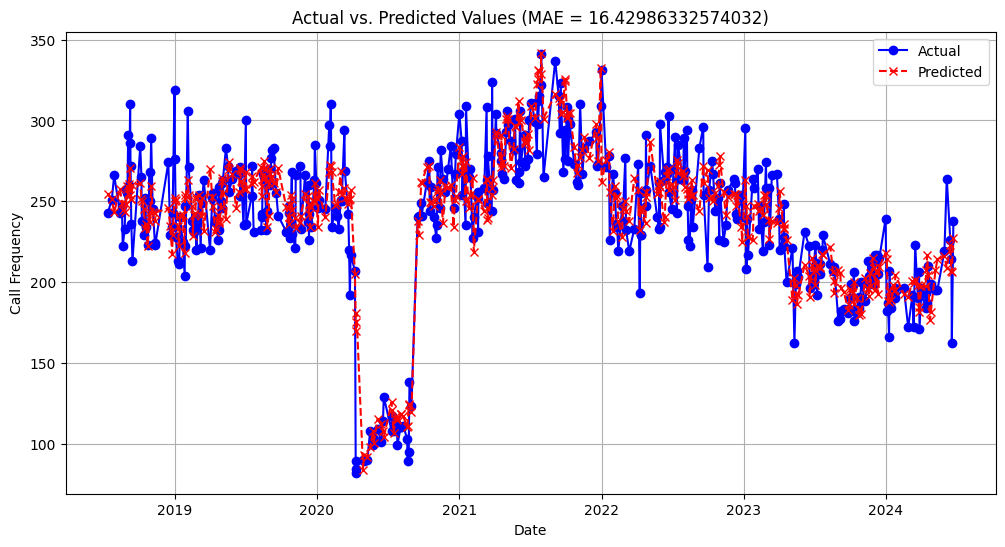

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(results_df.index, results_df['Actual'], label="Actual", marker='o', linestyle='-', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label="Predicted", marker='x', linestyle='--', color='red')

plt.xlabel("Date")
plt.ylabel("Call Frequency")
plt.title(f"Actual vs. Predicted Values (MAE = {mae1})")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
results_df['Delta'] = results_df['Actual'] - results_df['Predicted']
results_df

,Actual,Predicted,Delta
Date,,,
2018-07-14,243,254.29,-11.29
2018-07-24,251,251.36,-0.36
2018-07-30,266,243.06,22.94
2018-08-14,243,257.68,-14.68
2018-08-19,247,248.81,-1.81
...,...,...,...
2024-06-05,264,208.72,55.28
2024-06-14,226,222.83,3.17
2024-06-17,214,206.56,7.44


### Running with 2020 Removed

In [44]:
# Remove 2020 data
excl_2020 = freq_count[~((freq_count['Date'].dt.year == 2020) & (freq_count['Date'].dt.month.between(3, 10)))].reset_index(drop=True)

# # Model
excl_2020 = add_features(excl_2020)
x_train, x_test, y_train, y_test = train_test(excl_2020)
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

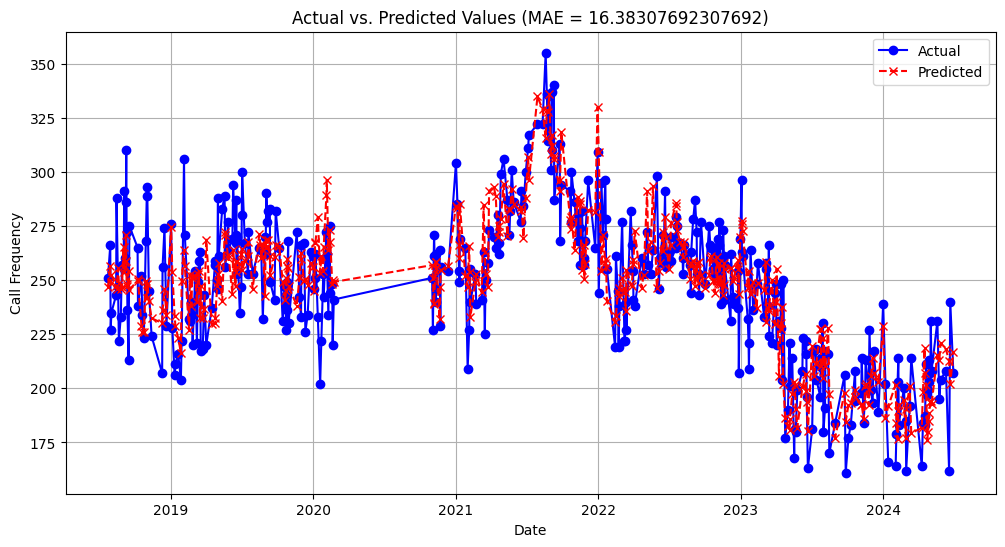

In [45]:
# Mean Absolute Error
mae2 = mean_absolute_error(y_test, y_pred)

# Create Date column for plotting
x_test['Date'] = pd.to_datetime(x_test[['Year', 'Month', 'Day']])

# Set Date column as dataframe index
x_test = x_test.set_index('Date')

# Update y_test index to be same as x_test - Date
y_test = y_test.set_axis(x_test.index)

# Create Dataframe to compare Actual vs Predicted
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=x_test.index)

# Sort by Date
results_df = results_df.sort_index()

# Plot
plt.figure(figsize=(12, 6))

plt.plot(results_df.index, results_df['Actual'], label="Actual", marker='o', linestyle='-', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label="Predicted", marker='x', linestyle='--', color='red')

plt.xlabel("Date")
plt.ylabel("Call Frequency")
plt.title(f"Actual vs. Predicted Values (MAE = {mae2})")
plt.legend()
plt.grid(True)
plt.show()

Removing months 3 - 10 in 2020 due to them being possible outliers decreases the MAE from 16.43 to 16.38.

### Building the Model - LSTM

In [46]:
# Call frequency by date
freq_count = ems_df.groupby('Date').size().reset_index(name='Count')
freq_count['Date'] = pd.to_datetime(freq_count['Date'])
freq_count.set_index('Date', inplace=True)
freq_count

,Count
Date,
2018-07-01,287
2018-07-02,285
2018-07-03,279
2018-07-04,225
2018-07-05,267
...,...
2024-06-26,220
2024-06-27,240
2024-06-28,218


In [47]:
def str_to_datetime(s):
    """
    Given date as a string, converts to datetime format
    """
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [48]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    """
    """
    # Converts string date to datetime
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    
    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
          print(f'Error: Window of size {n} is too large for date {target_date}')
          return
        
        values = df_subset['Count'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
          break
        
        target_date = next_date
        
        if target_date == last_date:
          last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y
    
    return ret_df

In [49]:
# Windowed dataframe
windowed_df = df_to_windowed_df(freq_count,'2018-07-04', '2024-06-30', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-07-04,287,285,279,225
1,2018-07-05,285,279,225,267
2,2018-07-06,279,225,267,228
3,2018-07-07,225,267,228,207
4,2018-07-08,267,228,207,215
...,...,...,...,...,...
2184,2024-06-26,242,214,239,220
2185,2024-06-27,214,239,220,240
2186,2024-06-28,239,220,240,218
2187,2024-06-29,220,240,218,207


In [50]:
def windowed_df_to_date_X_y(windowed_dataframe):
    """
    Transforms windowed dataframe into numpy array to feed into Tensorflow
    X - model input (date and target values)
    y - model output (supervised learning)
    """
    df_as_np = windowed_dataframe.to_numpy()

    # Date column - all rows, first column
    dates = df_as_np[:, 0]

    # Target values - all rows, all columns but first and last
    middle_matrix = df_as_np[:, 1:-1]

    # len(dates) - used to get size of first dimension (how many rows)
    # middle_matrix.shape[1] - gives number of columns (2nd dimension)
    # 1 - specifies 3rd dimension has size 1 - univariate forecasting
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2189,), (2189, 3, 1), (2189,))

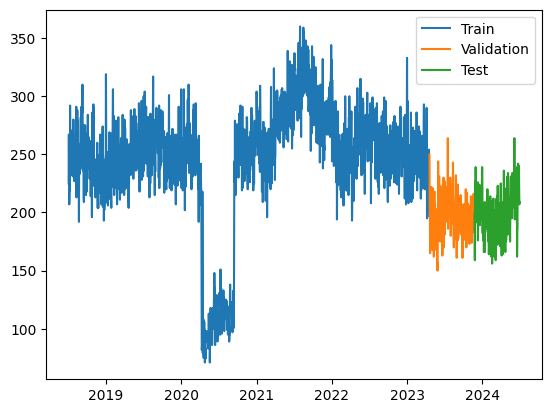

In [51]:
# Data split
# Training data - 80%
q_80 = int(len(dates) * 0.8)

# Validation data - 80-90%
q_90 = int(len(dates) * 0.9)

# (Testing data - final 10%)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [52]:
from tensorflow.keras.models import Sequential  # Sequential model
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras import layers  # Model with layers

In [53]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61933.6289 - mean_absolute_error: 243.3608 - val_loss: 36755.8125 - val_mean_absolute_error: 190.8247
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55931.6719 - mean_absolute_error: 230.7833 - val_loss: 18853.9980 - val_mean_absolute_error: 136.0458
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25777.0000 - mean_absolute_error: 149.8327 - val_loss: 476.5965 - val_mean_absolute_error: 17.4400
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2653.5369 - mean_absolute_error: 40.3063 - val_loss: 1110.9938 - val_mean_absolute_error: 28.5483
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 646.7816 - mean_absolute_error: 19.6491 - val_loss: 586.4464 - val_mean_absolute_error: 19.7787
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 538.9581 - mean_absolute_error: 18.3492 - val_loss: 848.6584 - val_mean_absolute_error: 24.2244
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


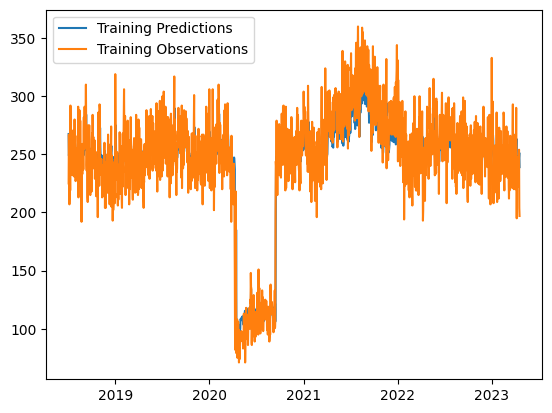

In [54]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


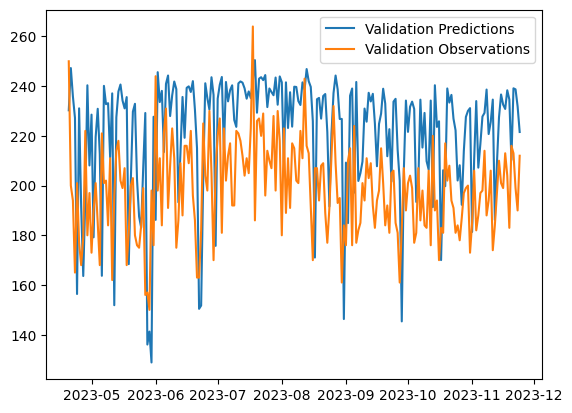

In [55]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


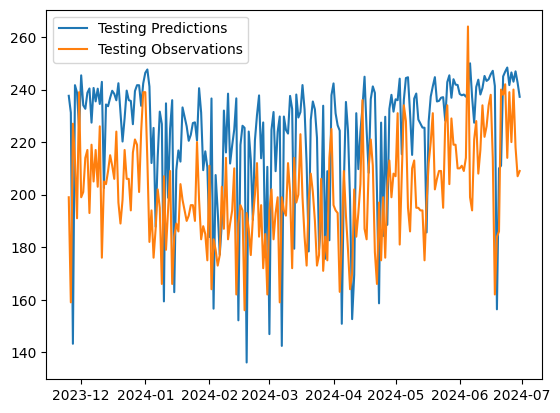

In [56]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

### References

Random Forest Regression/Scikit - https://www.youtube.com/watch?v=YUsx5ZNlYWc&t=430s&ab_channel=Ryan%26MattDataScience
<br>
LSTM/Tensorflow - https://www.youtube.com/watch?v=CbTU92pbDKw&ab_channel=GregHogg